## Radynversion Training Notebook

This notebook is used to train the Radynversion neural network. It requires the following packages:

`numpy`

`scipy`

`matplotlib`

`FrEIA: https://github.com/VLL-HD/FrEIA`

`pytorch >= 0.4.1` (only tested on `0.4.1` but will probably be updated to `1.0.x` soon -- I don't forsee any problems with this).

An NVIDIA GPU with CUDA and > 2GB VRAM is strongly recommended if you are going to attempt to train a Radynversion model. With a 1050 Ti, the full 12000 epochs are trained in under a day.

The hyperparameters listed here (learning rate, loss weights etc.) have all been empirically found to work, but changing the data may well necessitate changing these.

To (re)train Radynversion this notebook can be run pretty much from top to bottom, with only a little tweaking of the hyperparameters necessary if you change the the complexity of the input data.

A lot of the heavy lifting functions are in the files `Inn2.py` and `Loss.py`.

Please forgive the massive blobs of plotting code, the same technique is used to plot the results from the inversions and is nicely tucked away in `utils.py`, most of that code organically grew in this notebook!

To (re)train the model you will also need the training data. Either look at the ridiculously named `ExportSimpleLineBlobForTraining.py` to export the required data from your own RADYN sims/move around the atmospheric nodes etc. or use our _even_ more ridiculously named training data `DoublePicoGigaPickle50.pickle` which will be made available, along with the trained for the initial release of Radynversion on Radynversion's Github releases page. The training pickle contains all of the snapshots from the Fokker-Planck RADYN simulations in the F-CHROMA grid, sampled at the 50 atmospheric points detailed in Osborne, Armstrong, and Fletcher (2019).

In [1]:
%matplotlib notebook

from Inn2 import RadynversionNet, AtmosData, RadynversionTrainer
import loss as Loss
import pickle
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.utils.data
import os

from time import time

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Load the training data -- you will need to modify this path.

In [4]:
dataLocation1 = '/local0/scratch/HAlphaGridExportStatic/DoublePicoGigaPickle50.pickle'

data = AtmosData([dataLocation1], resampleWl=31)
data.split_data_and_init_loaders(500)

Construct the DataSchemas (descriptions of the network's inputs and outputs), and construct the network model using these.

In [6]:
inRepr = [('ne', data.ne.shape[1]), ('temperature', data.temperature.shape[1]), ('vel', data.vel.shape[1]), ('!!PAD',)]
outRepr = [('LatentSpace', 200), ('!!PAD',), ('Halpha', data.lines[0].shape[1]), ('Ca8542', data.lines[1].shape[1])]
model = RadynversionNet(inRepr, outRepr, dropout=0.00, zeroPadding=0, minSize=384, numInvLayers=5)

Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (384,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (384,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (384,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (384,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (384,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (384,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (384,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (384,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (384,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (384,)



In [1]:
# Optionally print the constructed DataSchemas and the string representation of the model.
# model.inSchema, model.outSchema, model

Construct the class that trains the model, the initial weighting between the losses, learning rate, and the initial number of epochs to train for.

In [8]:
trainer = RadynversionTrainer(model, data, dev)
trainer.training_params(800, lr=1.5e-3, zerosNoiseScale=5e-2, wPred=4000.0, wLatent=900.0, wRev=1000.0,
                        loss_latent=Loss.mmd_multiscale_on(dev, alphas=[8, 11]),
                        loss_backward=Loss.mmd_multiscale_on(dev, alphas=[1.4, 2, 5.5, 7]),
                        loss_fit=Loss.mse)
totalEpochs = 0

Train the model for these first epochs with a nice graph that updates during training.

In [ ]:
losses = []
lossVec = [[] for _ in range(4)]
lossLabels = ['L2 Line', 'MMD Latent', 'MMD Reverse', 'L2 Reverse']
out = None
fig, axis = plt.subplots(4,1, figsize=(10,8))
fig.show()
fig.canvas.draw()
alphaRange, mmdF, mmdB, idxF, idxB = [1,1], [1,1], [1,1], 0, 0
try:
    tStart = time()
    for epoch in range(trainer.numEpochs):
        totalEpochs += 1

        trainer.scheduler.step()
        
        loss, indLosses = trainer.train(epoch)
        
        axis[0].clear()
        axis[1].clear()
        axis[2].clear()
        axis[3].clear()
        if epoch > 5:
            for i in range(len(indLosses)):
                lossVec[i].append(indLosses[i])
            losses.append(loss)
            fig.suptitle('Current Loss: %.2e, min loss: %.2e' % (loss, np.nanmin(np.abs(losses))))
            axis[0].semilogy(np.arange(len(losses)), np.abs(losses))
            for i, lo in enumerate(lossVec):
                axis[1].semilogy(np.arange(len(losses)), lo, '--', label=lossLabels[i])
            axis[1].legend(loc='upper left')
            tNow = time()
            elapsed = int(tNow - tStart)
            eta = int((tNow - tStart) / (epoch + 1) * trainer.numEpochs) - elapsed

            if epoch % 2 == 0:
                mses = trainer.test(maxBatches=1)
                lineProfiles = mses[2]
                
            if epoch % 10 == 0:
                alphaRange, mmdF, mmdB, idxF, idxB = trainer.review_mmd()
                
            axis[3].semilogx(alphaRange, mmdF, label='Latent Space')
            axis[3].semilogx(alphaRange, mmdB, label='Backward')
            axis[3].semilogx(alphaRange[idxF], mmdF[idxF], 'ro')
            axis[3].semilogx(alphaRange[idxB], mmdB[idxB], 'ro')
            axis[3].legend()

            testTime = time() - tNow
            axis[2].plot(lineProfiles[0, model.outSchema.Halpha].cpu().numpy())
            axis[2].plot(lineProfiles[0, model.outSchema.Ca8542].cpu().numpy())
            for a in axis:
                a.grid()
            axis[3].set_xlabel('Epochs: %d, Elapsed: %d s, ETA: %d s (Testing: %d s)' % (epoch, elapsed, eta, testTime))
            
            
        fig.canvas.draw()

except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-tStart)/60:.2f} minutes\n")

Test the output of the model. The first number is the L2 on the forward process generated line profiles, while the second is the MMD between atmosphere generated by backwards model and the expected atmosphere (and padding).

In [ ]:
trainer.test(maxBatches=-1)[:2]

Define functions to allows us to save and load the model and associated machinery in a way that allows us to continue training if desired.

In [ ]:
# https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/4
def training_checkpoint():
    return {
        'epoch': totalEpochs,
        'state_dict': model.state_dict(),
        'optimizer': trainer.optim.state_dict(),
        'scheduler': trainer.scheduler.state_dict(),
        'inRepr': inRepr,
        'outRepr': outRepr
    }

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename):
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename)
            global totalEpochs
            totalEpochs = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            trainer.optim.load_state_dict(checkpoint['optimizer'])
            trainer.scheduler.load_state_dict(checkpoint['scheduler'])
            inRepr = checkpoint['inRepr']
            outRepr = checkpoint['outRepr']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(filename))

Do repeated iterations of the training, up to 12000 epochs. Save a model every 600 epochs. This takes quite a while and makes a new plot for each of the 600 epoch batches.

In [ ]:
prevTest = trainer.test(maxBatches=-1)
while True:
    save_checkpoint(training_checkpoint(), filename='checkpt_'+str(totalEpochs)+'_'+str(int(trainer.wPred))+'.pth.tar')
    trainer.numEpochs = 600
    trainer.fadeIn = False
    trainer.wPred += 1000
    
    # Do the training iter --  this is just a horrible copy and paste from above
    losses = []
    lossVec = [[] for _ in range(4)]
    lossLabels = ['L2 Line', 'MMD Latent', 'MMD Reverse', 'L2 Reverse']
    out = None
    fig, axis = plt.subplots(4,1, figsize=(10,8))
    fig.show()
    fig.canvas.draw()
    alphaRange, mmdF, mmdB, idxF, idxB = [1,1], [1,1], [1,1], 0, 0
    try:
        tStart = time()
        for epoch in range(trainer.numEpochs):
            totalEpochs += 1

            trainer.scheduler.step()

            loss, indLosses = trainer.train(epoch)

            axis[0].clear()
            axis[1].clear()
            axis[2].clear()
            axis[3].clear()
            if epoch > 5:
                for i in range(len(indLosses)):
                    lossVec[i].append(indLosses[i])
                losses.append(loss)
                fig.suptitle('Current Loss: %.2e, min loss: %.2e' % (loss, np.nanmin(np.abs(losses))))
                axis[0].semilogy(np.arange(len(losses)), np.abs(losses))
                for i, lo in enumerate(lossVec):
                    axis[1].semilogy(np.arange(len(losses)), lo, '--', label=lossLabels[i])
                axis[1].legend(loc='upper left')
                tNow = time()
                elapsed = int(tNow - tStart)
                eta = int((tNow - tStart) / (epoch + 1) * trainer.numEpochs) - elapsed

                if epoch % 2 == 0:
                    mses = trainer.test(maxBatches=1)
                    lineProfiles = mses[2]

                if epoch % 10 == 0:
                    alphaRange, mmdF, mmdB, idxF, idxB = trainer.review_mmd()

                axis[3].semilogx(alphaRange, mmdF, label='Latent Space')
                axis[3].semilogx(alphaRange, mmdB, label='Backward')
                axis[3].semilogx(alphaRange[idxF], mmdF[idxF], 'ro')
                axis[3].semilogx(alphaRange[idxB], mmdB[idxB], 'ro')
                axis[3].legend()

                testTime = time() - tNow
                axis[2].plot(lineProfiles[0, model.outSchema.Halpha].cpu().numpy())
                axis[2].plot(lineProfiles[0, model.outSchema.Ca8542].cpu().numpy())
                for a in axis:
                    a.grid()
                axis[3].set_xlabel('Epochs: %d, Elapsed: %d s, ETA: %d s (Testing: %d s)' % (epoch, elapsed, eta, testTime))


            fig.canvas.draw()

    except KeyboardInterrupt:
        pass
    finally:
        print(f"\n\nTraining took {(time()-tStart)/60:.2f} minutes\n")
        
    test = trainer.test(maxBatches=-1)
    print(test[0], test[1])
    
    if totalEpochs >= 12000:
        save_checkpoint(training_checkpoint(), filename='checkpt_'+str(totalEpochs)+'_'+str(int(trainer.wPred))+'.pth.tar')
        break
    

Loop over all the checkpoint files in the current directory, and compute their accuracy on the unseen testing set

In [ ]:
files = [f for f in os.listdir() if f.startswith('checkpt_') and f.endswith('.pth.tar')]
numerical = [int(f.split('_')[1]) for f in files]
files = [f[1] for f in sorted(zip(numerical, files))]

for f in files:
    load_checkpoint(f)
    print(trainer.test(maxBatches=-1)[:2])

This cell can be used to load desired model from the information produced by the previous cell. Just change the argument to numerical.index to the number of epochs the desirec checkpoint was trained for. It will spit out the losses again.

In [ ]:
files = [f for f in os.listdir() if f.startswith('checkpt_') and f.endswith('.pth.tar')]
numerical = [int(f.split('_')[1]) for f in files]
idx = numerical.index(11400)
load_checkpoint(files[idx])
trainer.test(maxBatches=-1)[:2]

Define a function to transform from out log-ish velocity to km/s

In [10]:
def logvel_to_vel(v):
    vSign = v / torch.abs(v)
    vSign[torch.isnan(vSign)] = 0
    vel = vSign * (10**torch.abs(v) - 1.0)
    return vel

Define a little helper class to better format matplotlib's offset on the x-axis for the huge numbers of cm we're using here!

In [90]:
import matplotlib.ticker
class oom_formatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self,order=0,fformat="%1.1f",offset=True,math_text=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=math_text)
        
    def _set_orderOfMagnitude(self,nothing):
        self.orderOfMagnitude = self.oom
        
    def _set_format(self, v_min, v_max):
        self.format = self.fformat
        if self._useMathText:
            self.format = "$%s$" % matplotlib.ticker._mathdefault(self.format)

Test a random unseen atmosphere with the forward model and compare against the validation data with a nice plot. You may need to run this (quite) a few times to get an atmosphere that produces the line shapes you were looking for. This should produce a different result every time.

<IPython.core.display.Javascript object>


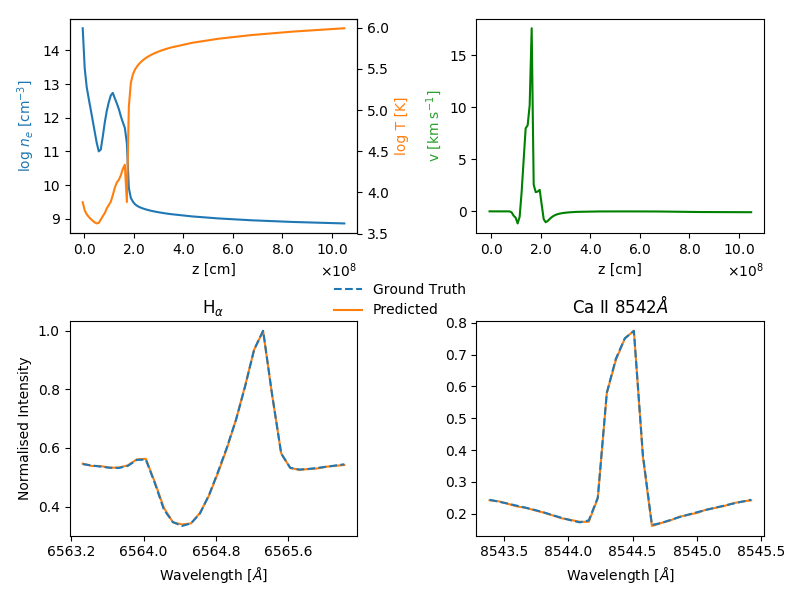

In [94]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
    x = x.to(dev)
    pad_fn = lambda *x: torch.zeros(*x, device=dev)
    inp = model.inSchema.fill({'ne': x[:, 0],
                                'temperature': x[:, 1],
                                'vel': x[:, 2]},
                               zero_pad_fn=pad_fn)
    
    yz = model(inp.to(dev))
    fig, ax = plt.subplots(2,2, figsize=(8,6))
    ax = ax.ravel()
    ax = [ax[0], ax[0].twinx(), *ax[1:]]
    ax[0].plot(data.z.numpy(), x[0, 0].cpu().numpy())
    ax[1].plot(data.z.numpy(), x[0, 1].cpu().numpy(), color='C1')
    ax[2].plot(data.z.numpy(), logvel_to_vel(x[0, 2].cpu()).numpy(), color='green')
    ax[3].plot(data.wls[0].numpy(), y[0, 0].numpy(), '--', zorder=3)
    ax[3].plot(data.wls[0].numpy(), yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[4].plot(data.wls[1].numpy(), y[0, 1].numpy(), '--', zorder=3, label='Ground Truth')
    ax[4].plot(data.wls[1].numpy(), yz[0, model.outSchema.Ca8542].cpu().numpy(), label='Predicted')
    ax[0].set_ylabel('log $n_e$ [cm$^{-3}$]', color='C0')
    ax[1].set_ylabel('log T [K]', color='C1')
    ax[2].set_ylabel('v [km s$^{-1}$]', color='C2')
    ax[3].set_ylabel('Normalised Intensity')
    ax[0].set_xlabel('z [cm]')
    ax[2].set_xlabel('z [cm]')
    ax[3].set_xlabel(r'Wavelength [$\AA$]')
    ax[4].set_xlabel(r'Wavelength [$\AA$]')
    ax[3].set_title(r'H$_\alpha$')
    ax[4].set_title(r'Ca II 8542$\AA$')
    ax[0].xaxis.set_major_formatter(oom_formatter(8))
    ax[2].xaxis.set_major_formatter(oom_formatter(8))
    ax[3].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[4].xaxis.set_major_locator(plt.MaxNLocator(5))
    fig.legend(loc='center', frameon=False)
    fig.tight_layout()
    fig.show()
    fig.canvas.draw()

In [95]:
# Save the above figure if desired
fig.savefig('ForwardProcess2.png', dpi=300)

Test the model's inverse solution on a random validation sample from the test set, with `batchSize` number of random draws from the latent space, plot these results and the round-trip line profiles. The interpretation of these figures is discussed in the paper, but in short, the bars on the 2D histogram for the atmospheric profiles show the probability of the parameter value at each atmospheric node. The dashed black lines show the expected solution. The thin bars on the line profiles show the round trip (i.e. forward(inverse(lineProfiles))) in histogram form.

<IPython.core.display.Javascript object>


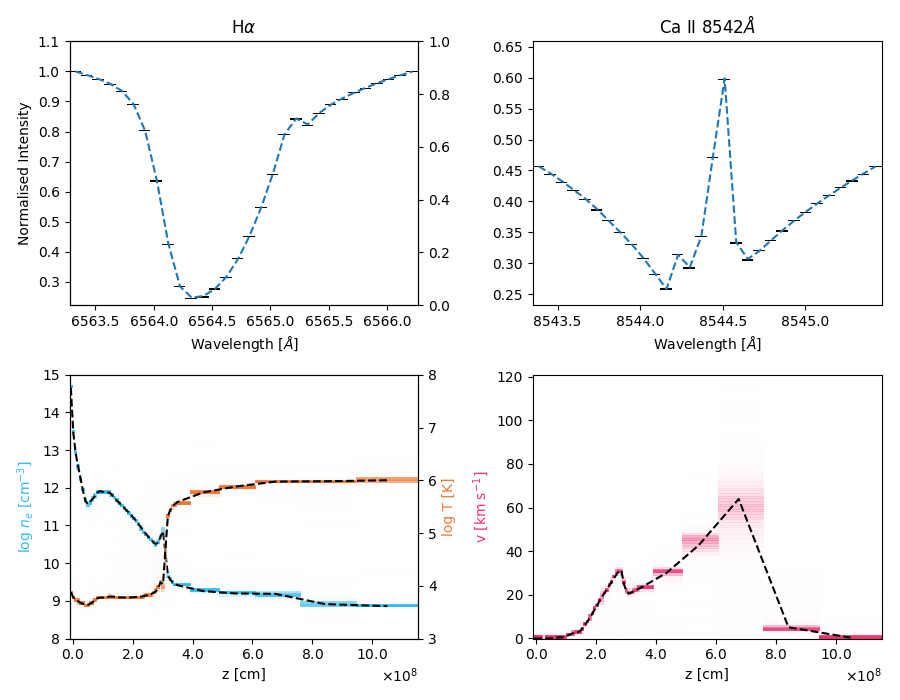

CPU times: user 1.54 s, sys: 632 ms, total: 2.18 s
Wall time: 1.53 s


In [106]:
%%time
from matplotlib.colors import LogNorm, PowerNorm, LinearSegmentedColormap
    
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
    batchSize = 40000
    y = torch.ones((batchSize, *y.shape[1:])) * y[0, :, :]
    y = y.to(dev)
    randn = lambda *x: torch.randn(*x, device=dev)
    yz = model.outSchema.fill({'Halpha': y[:, 0], 'Ca8542': y[:, 1], 'LatentSpace': randn}, zero_pad_fn=pad_fn)
    xOut = model(yz.to(dev), rev=True)
    
    yzRound = model(xOut)
    zEdges = [data.z[0] - 0.5 * (data.z[1] - data.z[0])]
    for i in range(data.z.shape[0] - 1):
        zEdges.append(0.5 * (data.z[i] + data.z[i+1]))
    zEdges.append(data.z[-1] + 0.5 * (data.z[-1] - data.z[-2]))
    
    wlHaEdges = [data.wls[0][0] - 0.5 * (data.wls[0][1] - data.wls[0][0])]
    for i in range(data.wls[0].shape[0] - 1):
        wlHaEdges.append(0.5 * (data.wls[0][i] + data.wls[0][i+1]))
    wlHaEdges.append(data.wls[0][-1] + 0.5 * (data.wls[0][-1] - data.wls[0][-2]))
    
    wlCaEdges = [data.wls[1][0] - 0.5 * (data.wls[1][1] - data.wls[1][0])]
    for i in range(data.wls[1].shape[0] - 1):
        wlCaEdges.append(0.5 * (data.wls[1][i] + data.wls[1][i+1]))
    wlCaEdges.append(data.wls[1][-1] + 0.5 * (data.wls[1][-1] - data.wls[1][-2]))
    
    neEdges = np.linspace(8, 15, num=101)
    tEdges = np.linspace(3, 8, num=101)
    minVel = np.min(np.median(xOut[:, model.inSchema.vel], axis=0))
    minVel = np.sign(minVel) * 2 * np.abs(minVel) if minVel <= 0 else 0.9 * minVel
    maxVel = 2 * np.max(np.median(logvel_to_vel(xOut[:, model.inSchema.vel]), axis=0))
    velEdges = np.linspace(minVel, maxVel, num=101)
    
    haIntEdges = np.linspace(0.9 * np.min(np.median(yzRound[:, model.outSchema.Halpha], axis=0)), 1.1 * np.max(np.median(yzRound[:, model.outSchema.Halpha], axis=0)), num=201)
    caIntEdges = np.linspace(0.9 * np.min(np.median(yzRound[:, model.outSchema.Ca8542], axis=0)), 1.1 * np.max(np.median(yzRound[:, model.outSchema.Ca8542], axis=0)), num=201)
    
    cmapNe = [(1.0,1.0,1.0,0.0), (51/255, 187/255, 238/255, 1.0)]
    neColors = LinearSegmentedColormap.from_list('ne', cmapNe)
    cmapTemp = [(1.0,1.0,1.0,0.0), (238/255, 119/255, 51/255, 1.0)]
    tempColors = LinearSegmentedColormap.from_list('temp', cmapTemp)
    cmapVel = [(1.0,1.0,1.0,0.0), (238/255, 51/255, 119/255, 1.0)]
    velColors = LinearSegmentedColormap.from_list('vel', cmapVel)

        
    fig, ax = plt.subplots(2, 2, figsize=(9,7))
    ax1 = ax[0,0].twinx()
    ax = ax.ravel()
    ax = [*ax[:3], ax[2].twinx(), *ax[3:]]
    
    ax[0].plot(data.wls[0].numpy(), yz[0, model.outSchema.Halpha].cpu().numpy(), '--', zorder=3)
    ax[1].plot(data.wls[1].numpy(), yz[0, model.outSchema.Ca8542].cpu().numpy(), '--', zorder=3)
    
    powerIdx = 0.3
    ax[0].hist2d(torch.cat([data.wls[0]] * yzRound.shape[0]).numpy(), yzRound[:, model.outSchema.Halpha].cpu().numpy().reshape((-1,)), bins=(wlHaEdges, haIntEdges), cmap='gray_r', norm=PowerNorm(powerIdx))
    ax[1].hist2d(torch.cat([data.wls[1]] * yzRound.shape[0]).numpy(), yzRound[:, model.outSchema.Ca8542].cpu().numpy().reshape((-1,)), bins=(wlCaEdges, caIntEdges), cmap='gray_r', norm=PowerNorm(powerIdx))
    ax[2].hist2d(torch.cat([data.z] * xOut.shape[0]).numpy(), xOut[:, model.inSchema.ne].cpu().numpy().reshape((-1,)), bins=(zEdges, neEdges), cmap=neColors, norm=PowerNorm(powerIdx))
    ax[3].hist2d(torch.cat([data.z] * xOut.shape[0]).numpy(), xOut[:, model.inSchema.temperature].cpu().numpy().reshape((-1,)), bins=(zEdges, tEdges), cmap=tempColors, norm=PowerNorm(powerIdx))
    ax[4].hist2d(torch.cat([data.z] * xOut.shape[0]).numpy(), logvel_to_vel(xOut[:, model.inSchema.vel].cpu()).numpy().reshape((-1,)), bins=(zEdges, velEdges), cmap=velColors, norm=PowerNorm(powerIdx))
    
    ax[2].plot(data.z.numpy(), x[0, 0].numpy(), 'k--')
    ax[3].plot(data.z.numpy(), x[0, 1].numpy(), 'k--')
    ax[4].plot(data.z.numpy(), logvel_to_vel(x[0, 2]).numpy(), 'k--')
    
    ax[0].set_title(r'H$\alpha$')
    ax[1].set_title(r'Ca II 8542$\AA$')
    ax[0].set_xlabel(r'Wavelength [$\AA$]')
    ax[1].set_xlabel(r'Wavelength [$\AA$]')
    ax[0].set_ylabel(r'Normalised Intensity')
    
    ax[2].set_xlabel('z [cm]')
    ax[4].set_xlabel('z [cm]')
    ax[2].set_ylabel(r'log $n_e$ [cm$^{-3}$]', color=(cmapNe[-1]))
    ax[3].set_ylabel(r'log T [K]', color=(cmapTemp[-1]))
    ax[4].set_ylabel(r'v [km s$^{-1}$]', color=(cmapVel[-1]))
    ax[2].xaxis.set_major_formatter(oom_formatter(8))
    ax[4].xaxis.set_major_formatter(oom_formatter(8))
    fig.tight_layout()

In [107]:
# Save the above figure if desired
fig.savefig('InverseProcess2.png', dpi=300)